# Neural Process example implementation for Mixture Density Learning

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import jax
import jax.numpy as jnp

from torch.utils.data import Dataset
from torch.utils.data import Subset

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


cuda? [CpuDevice(id=0)] cpu


In [5]:
# Test-configuration
dataset_size = 100
test_resolution = 500

In [6]:
# Train-configuration
num_posterior_mc = 10  # number of latents to sample from p(Z | X, Y)
batch_size = 256  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 128
num_context_samples = 256

In [7]:
class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

## Define Training Distribution/ Data-Generation

In [8]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [9]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

In [10]:
class MixtureDataset(Dataset):
    def __init__(self, dataset_size, key, num_context_samples, num_target_samples, sampler):
        self.key = key
        self.dataset_size = dataset_size
        self.num_context_samples = num_context_samples
        self.num_target_samples = num_target_samples
        self.sampler = sampler
        self.context_xs, self.target_xs, self.context_ys, self.target_ys = self._get_data()
        
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.context_xs[idx], self.context_ys[idx], self.target_xs[idx], self.target_ys[idx]

    def _get_data(self):
        key_data, self.key = jax.random.split(self.key)
        xs, ys = jax.vmap(self.sampler)(jax.random.split(key_data, num=self.dataset_size))
        xs, ys = xs[..., None], ys[..., None]
        # Split into context- and target-points.
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)
        return X, x_test, y, y_test


In [11]:
# Specify which function-prior to learn
data_sampler = partial(
    joint, 
    Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

rng, key = jax.random.split(rng)
# xs, ys = data_sampler(key)

# X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
# y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))
# 
# sns.jointplot(x=xs, y=ys)
# sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return xs_context, ys_context, xs_target, ys_target
#rng, key = jax.random.split(rng)

dataset = MixtureDataset(dataset_size=100, key=key, num_context_samples=256, num_target_samples=128, sampler=data_sampler)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=numpy_collate)
data_iter = iter(dataloader)
x_context, y_context, x_target, y_target = next(iter(dataloader))
print(x_context.shape)
print(y_context.shape)
print(x_target.shape)
print(y_target.shape)
print(dataset.__len__())


(100, 256, 1)
(100, 256, 1)
(100, 128, 1)
(100, 128, 1)
100


## Define Test-Case

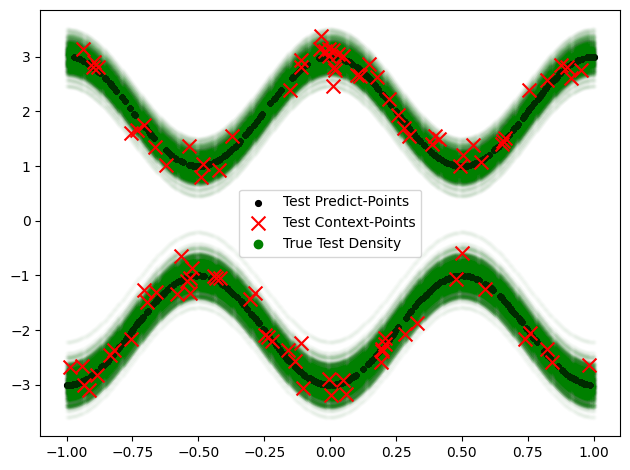

In [12]:

def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale
    choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

# Define the Model

In [13]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))

output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([128, 128, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

/tmp/ipykernel_18425/2886687022.py:32: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


### Test-predictions at init

In [14]:
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:, None], 
    k=15,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (500, 15, 1) (500, 15, 1)


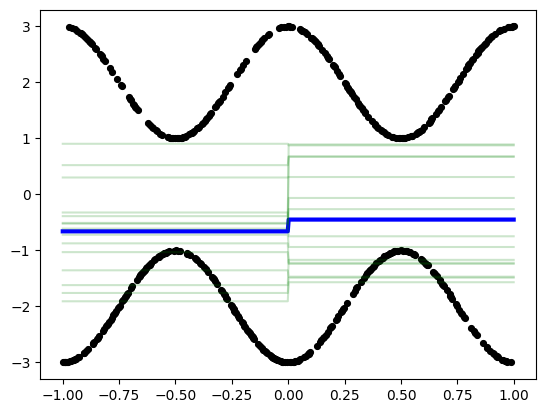

In [15]:
# Example predictions at init
plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

# Dummy Optimization/ Amortization procedure

In [16]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    key_data, key_model = jax.random.split(key)
    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


In [17]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [68]:
# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    batch = next(data_iter)
    x_context, y_context, x_target, y_target = next(iter(dataloader))
    params_new, opt_state, loss = step(params, opt_state, (x_context, y_context, x_target, y_target), key)

    losses.append(loss)

    if loss < best:
        best = loss
        best_params = params_new
    
    if jnp.isnan(loss):
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[1153760980 3446263651]


Optimizing params. Loss: 1.6401: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


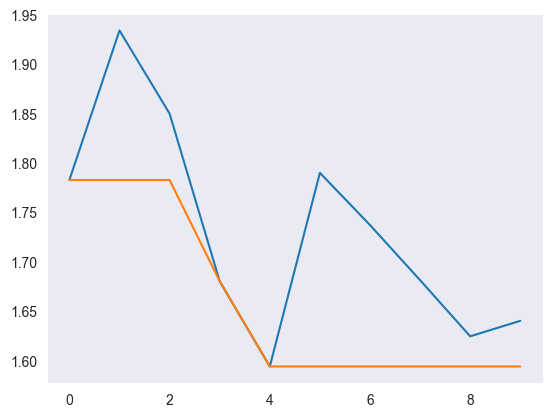

In [69]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

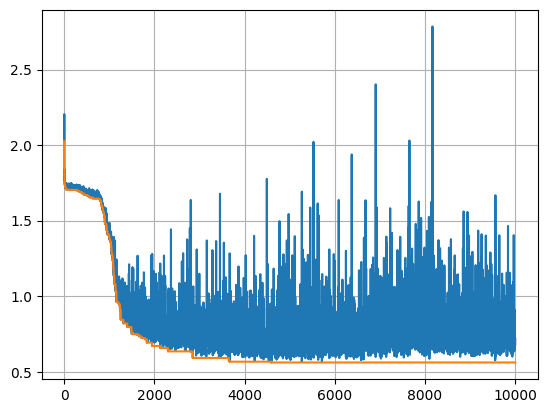

In [15]:
# Using q40 filtering

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

# Test-predictions after training

In [44]:
# Test predictions on functions from the training-distribution
rng, key = jax.random.split(rng)

x_train, y_train = data_sampler(key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(num_context_samples, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(num_context_samples, ))

# Compute ELBO over batch of datasets
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=10,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (500, 10, 1) (500, 10, 1)


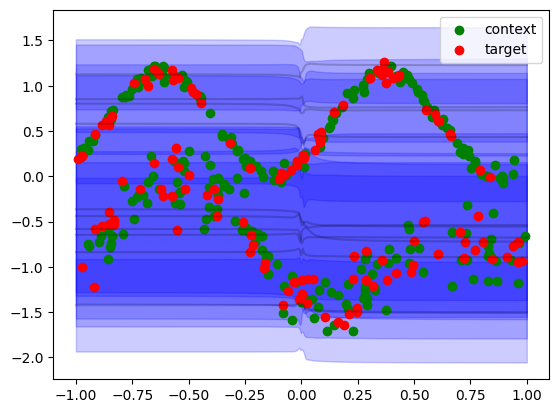

In [47]:
# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

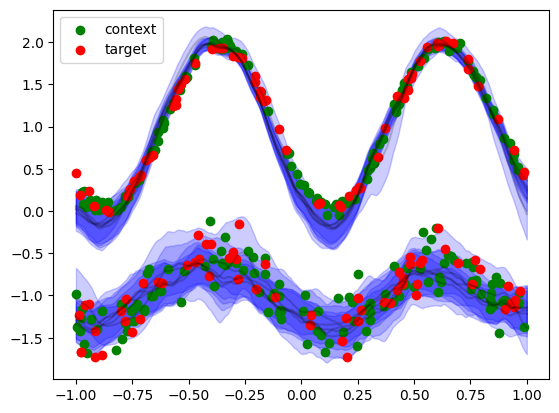

In [17]:
# Using q40 filtering

# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

# Code for SPL implemenation 

#### Regression pytorch dataset of map style dataset
#### SPL_Curriculum class for receiving a dataset and creating a dataloader with subset of current portion of easiest data points (chunked vmap calculation of losses)
#### dataset generator with chunked vmap

In [20]:
class RegressionDataset(Dataset):
    def __init__(self, dataset):
        self.context_xs, self.target_xs, self.context_ys, self.target_ys = dataset
        
    def __len__(self):
        return self.context_xs.shape[0]

    def __getitem__(self, idx):
        return self.context_xs[idx], self.context_ys[idx], self.target_xs[idx], self.target_ys[idx]

    def _get_data(self):

        return self.context_xs, self.context_ys, self.target_xs,  self.target_ys

In [49]:
# Lets setup the spl for a very small example so we can debug and make sure it would work on a basic level

# We have to setup the dataset + dataloader
# Create a SPL_curricula class to encapsulate a dataset, and the ordering , pacing logic
# For now lets hard code, the hard weight variant, with a linear pacing function, understood as portion of data being sampled
def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return xs_context, ys_context, xs_target, ys_target

class SPL_curriculum:
    def __init__(self, start_rate, growth_epochs, dataset, batch_size, rng, save_path):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_epochs= growth_epochs 
        self.dataset = dataset
        self.rng = rng
        self.weight_log = []
        # Initialize a memmap file for epoch indices
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.file = open(save_path, 'ab')   # Open the file in append mode




    def data_curriculum(self, model, params, epoch):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0
        if(epoch == 0):
            data_rate = self.start_rate

        else:

            data_rate =  min(1.0 , self.start_rate + (1.0 - self.start_rate) / self.growth_epochs * epoch)

        
        curr_data_size = int(data_rate * self.dataset.__len__())
        print('curr_data_size', curr_data_size, "curr_data_rate", data_rate, "epoch number" , epoch) 

        losses = self.calculate_difficulty_ordering(model, params)
        data_rate_percentile = jnp.percentile(losses , data_rate*100)
        sorted_indices = jnp.where(self.calculate_difficulty_ordering(model, params) <= data_rate_percentile)[0]
        print('sorted indices shape', sorted_indices.shape)
        if(curr_data_size < self.dataset.__len__()):
            np.save(self.file, sorted_indices)
        else:
            self.file.close()

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True, collate_fn=numpy_collate)  # Maybe shuffle? 
        # calculate the loss over the dataset with the current model and params
    
    def calculate_difficulty_ordering(self, model, params):

        """ Calculate the difficulty of the dataset based on the model and params
        """
        @jax.jit 
        def per_sample_loss(key_loss, x_b, y_b, x_test_b, y_test_b):
            return partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo)(x_b, y_b, x_test_b, y_test_b, rngs={'default': key_loss})
        chunk_size = self.batch_size
        # currently problem since self.dataset._get_data() returns tuple of 4 arrays, but we need to return a tuple of 4 arrays for each sample, so we need to do it in a different way
        

        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(per_sample_loss, in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        X_b, y_b, x_test_b, y_test_b = self.dataset._get_data() 
        losses = chunked_loss_f(key_losses, X_b, y_b, x_test_b, y_test_b) 
        return losses 





# Lets also setup the SepMeta implementation as it doesnt require argsort. 

class SPL_loss_curriculum():

    def __init__(self, start_rate, growth_pace, dataset, batch_size, rng, save_path):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_growth_pace = growth_pace 
        self.dataset = dataset
        self.rng = rng

        self.lambda_threshold= self.init_lambda(model, params)
        print('lambda threshold', self.lambda_threshold)
        self.weight_log = []
        # Initialize a memmap file for epoch indices


    def init_lambda(self, model, params):
        # lets compute the initial lambda, which is the loss value that would correspond to the start_rate thresholding

        losses = self.calculate_difficulty_ordering(model, params)
        losses_sorted = jnp.sort(losses)
        start_lambda = losses_sorted[int(self.start_rate * len(losses_sorted))]
        return start_lambda
    
    def data_curriculum(self, model, params, epoch ):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0


        losses = self.calculate_difficulty_ordering(model, params)

        lambda_threshold = self.lambda_threshold + self.growth_growth_pace * epoch

        sorted_indices = jnp.where(losses <= lambda_threshold)[0]
        print('sorted indices shape', sorted_indices.shape)

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True, collate_fn=numpy_collate)  # Maybe shuffle? 
        # calculate the loss over the dataset with the current model and params
 

    def calculate_difficulty_ordering(self, model, params):

        """ Calculate the difficulty of the dataset based on the model and params
        """
        @jax.jit 
        def per_sample_loss(key_loss, x_b, y_b, x_test_b, y_test_b):
            return partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo)(x_b, y_b, x_test_b, y_test_b, rngs={'default': key_loss})
        chunk_size = self.batch_size
        # currently problem since self.dataset._get_data() returns tuple of 4 arrays, but we need to return a tuple of 4 arrays for each sample, so we need to do it in a different way
        

        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(per_sample_loss, in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        X_b, y_b, x_test_b, y_test_b = self.dataset._get_data() 
        losses = chunked_loss_f(key_losses, X_b, y_b, x_test_b, y_test_b) 
        return losses 






In [36]:
# Trying out how to more efficiently produce the dataset 
data_sampler = partial(
    joint, 
    Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)
@partial(jax.jit, static_argnums=(1,2))
def gen_sampler_datapoint(key, num_context_samples, sampler):
    x, y = sampler(key)
    x, y = x[..., None], y[..., None]
    X, x_test = jnp.split(x, indices_or_sections=(num_context_samples,))
    y, y_test = jnp.split(y, indices_or_sections=(num_context_samples,))
    return X, x_test, y, y_test

@partial(jax.jit, static_argnums=(1,2,3,4))
def generate_dataset(rng , num_batches, num_context_samples, sampler, chunk_size):
    rng_old , key = jax.random.split(rng)
    keys = jax.random.split(rng, num_batches)
    # Apply the function in chunks using netket.jax.vmap_chunked
    batched_generate = nk.jax.vmap_chunked(
        partial(gen_sampler_datapoint, num_context_samples=num_context_samples, sampler=sampler),
        in_axes=0,
        chunk_size=chunk_size
    )
    X_tot, x_test_tot, y_tot, y_test_tot = batched_generate(keys)
    return X_tot, x_test_tot, y_tot, y_test_tot

In [22]:
# Trying out dataset generation and loss calculation / sorting with different dataset sizes.


num_batches = 256*10
chunk_size = 256*10
data = generate_dataset(rng, num_batches, num_context_samples, data_sampler, chunk_size)
print(data[0].shape , data[1].shape, data[2].shape, data[3].shape)
dataset = RegressionDataset(data)
spl_curricula = SPL_curriculum(0.1, 10, dataset, 256, rng, 'spl_metadata/spl_weights.npy' )




    

spl_curricula.data_curriculum(model, params, 0)
print(spl_curricula.dataset.__len__())

# trying out the weight saving and loading

weights = np.load('spl_metadata/spl_weights.npy', allow_pickle=True)
print(weights.shape)

(2560, 256, 1) (2560, 128, 1) (2560, 256, 1) (2560, 128, 1)
curr_data_size 256 curr_data_rate 0.1 epoch number 0
sorted indices shape (242,)
2560
(242,)


In [42]:

# Trying out the SPL_loss_curriculum , where the loss is used as a threshold. 

spl_loss_curricula = SPL_loss_curriculum(0.2, 0.1, dataset, 256, rng, 'spl_metadata/spl_loss_curr_weights.npy' )

spl_curricula.data_curriculum(model, params, 0)
print(weights.shape)

curr_data_size 256 curr_data_rate 0.1 epoch number 0
sorted indices shape (298,)


EOFError: No data left in file

In [44]:
# Lets setup the training loop with the SPL_curricula 


# TODO : Figure out , how to save the losses, given that the training data size changes across epochs comparted to baseline
# SOL? : Save the per batch losses only, and also somehow keep track of the epoch number, and display per batch loss , but also have the epoch number in the plot somehow? 

rng, key = jax.random.split(rng)

last_key = key
print(last_key)

dataset_size = 256*5
dataset_chunk_size = 256*5

# Dataset and curricula setup
dataset = RegressionDataset(generate_dataset(rng, dataset_size, num_context_samples, data_sampler, dataset_chunk_size))
spl_curricula = SPL_curriculum(0.1, 5, dataset, 32, rng)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    
    # Get the current data_curriculum dataloader based on the current epoch 
    
    current_dataloader = spl_curricula.data_curriculum(model, params, i)
    
    for batch in current_dataloader:
        x_context, y_context, x_target, y_target = batch
        params_new, opt_state, loss = step(params, opt_state, (x_context, y_context, x_target, y_target), key)

        losses.append(loss)

        if loss < best:
            best = loss
            best_params = params_new

        if jnp.isnan(loss):
            break
        else:
            params = params_new
   
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f} Best Loss: {best:.4f}')

params = best_params


Array((), dtype=key<fry>) overlaying:
[3111544526 2823317072]


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0


Optimizing params. Loss: 1.7865:  10%|█         | 1/10 [00:19<02:51, 19.03s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1


Optimizing params. Loss: 1.7204:  20%|██        | 2/10 [00:47<03:18, 24.75s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2


Optimizing params. Loss: 1.7441:  30%|███       | 3/10 [01:24<03:30, 30.01s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3


Optimizing params. Loss: 1.6850:  40%|████      | 4/10 [02:07<03:31, 35.26s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4


Optimizing params. Loss: 1.6142:  50%|█████     | 5/10 [02:58<03:25, 41.17s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5


Optimizing params. Loss: 1.6052:  60%|██████    | 6/10 [04:01<03:13, 48.44s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6


Optimizing params. Loss: 1.5726:  70%|███████   | 7/10 [04:53<02:29, 49.68s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7


Optimizing params. Loss: 1.5428:  80%|████████  | 8/10 [05:46<01:40, 50.50s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8


Optimizing params. Loss: 1.5501:  90%|█████████ | 9/10 [06:38<00:51, 51.17s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9


Optimizing params. Loss: 1.5430: 100%|██████████| 10/10 [07:31<00:00, 45.16s/it]


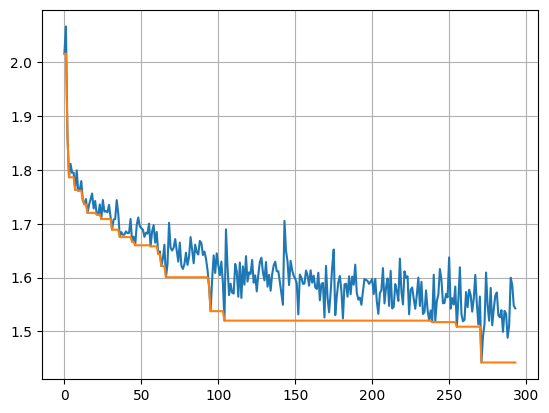

In [45]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

In [53]:

# TODO : Figure out , how to save the losses, given that the training data size changes across epochs comparted to baseline
# SOL? : Save the per batch losses only, and also somehow keep track of the epoch number, and display per batch loss , but also have the epoch number in the plot somehow? 

rng, key = jax.random.split(rng)

last_key = key
print(last_key)

dataset_size = 256*5
dataset_chunk_size = 256*5

# Dataset and curricula setup
dataset = RegressionDataset(generate_dataset(rng, dataset_size, num_context_samples, data_sampler, dataset_chunk_size))
spl_curricula =  SPL_loss_curriculum(0.1, 0.05, dataset, 32, rng , "")

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    
    # Get the current data_curriculum dataloader based on the current epoch 
    
    current_dataloader = spl_curricula.data_curriculum(model, params, i)
    
    for batch in current_dataloader:
        x_context, y_context, x_target, y_target = batch
        params_new, opt_state, loss = step(params, opt_state, (x_context, y_context, x_target, y_target), key)

        losses.append(loss)

        if loss < best:
            best = loss
            best_params = params_new

        if jnp.isnan(loss):
            break
        else:
            params = params_new
   
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f} Best Loss: {best:.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[3483527101 2691909880]
lambda threshold -1.7962817118941463


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

sorted indices shape (180,)


Optimizing params. Loss: 1.9541 Best Loss: 1.8303:  10%|█         | 1/10 [00:20<03:07, 20.87s/it]

sorted indices shape (265,)


Optimizing params. Loss: 1.7676 Best Loss: 1.7676:  20%|██        | 2/10 [00:37<02:25, 18.22s/it]

sorted indices shape (312,)


Optimizing params. Loss: 1.7822 Best Loss: 1.7554:  30%|███       | 3/10 [01:02<02:30, 21.49s/it]

sorted indices shape (526,)


Optimizing params. Loss: 1.7710 Best Loss: 1.7057:  40%|████      | 4/10 [01:27<02:17, 22.85s/it]

sorted indices shape (660,)


Optimizing params. Loss: 1.7034 Best Loss: 1.6725:  50%|█████     | 5/10 [01:57<02:06, 25.28s/it]

sorted indices shape (785,)


Optimizing params. Loss: 1.6576 Best Loss: 1.6502:  60%|██████    | 6/10 [02:30<01:52, 28.09s/it]

sorted indices shape (1004,)


Optimizing params. Loss: 1.6093 Best Loss: 1.6093:  70%|███████   | 7/10 [03:19<01:44, 34.88s/it]

sorted indices shape (1162,)


Optimizing params. Loss: 1.5462 Best Loss: 1.5462:  80%|████████  | 8/10 [04:06<01:17, 38.58s/it]

sorted indices shape (1136,)


Optimizing params. Loss: 1.5680 Best Loss: 1.5462:  90%|█████████ | 9/10 [04:59<00:43, 43.26s/it]

sorted indices shape (1224,)


Optimizing params. Loss: 1.6420 Best Loss: 1.5462: 100%|██████████| 10/10 [05:48<00:00, 34.83s/it]


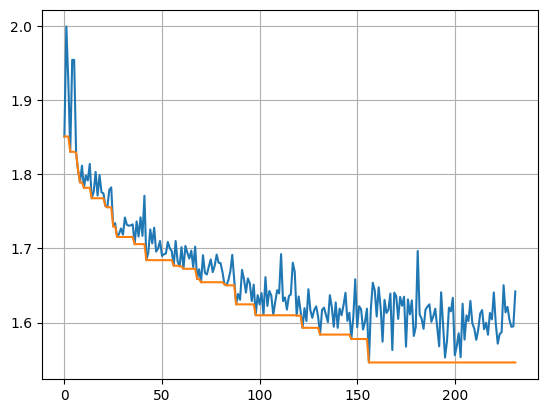

In [54]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

In [58]:
data = dataset._get_data()

data_loader_try = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in data_loader_try:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2].shape)
    print(batch[3].shape)
    break


TypeError: Only integer scalar arrays can be converted to a scalar index.